In [245]:
import torch
import torch.nn as nn 
import pandas as pd
import numpy as np
import time
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import datetime
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

In [246]:
from src.algorithms.LSTMAutoencoder import LSTMAutoencoderAlgo
from src.utils.util import *
from src.dataset.wadi import WadiDataset
from src.model.modelLSTM import Encoder,Decoder,LSTMAutoencoder

In [247]:
#This is the beginning of programm
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)
    


13:17:05


<h4>Initializing Dataset</h4>

In [248]:
class ArgsTrn:
    workers=4
    batch_size=32
    epochs=5
    lr=0.0002
    cuda = True
    manualSeed=2
    mean=0
    std=0.1
    
opt_trn=ArgsTrn()
torch.manual_seed(opt_trn.manualSeed)


class Datasettings:
    
    def __init__(self):
        self.dataset_training_name="/home/jupyter/GRANOGAN-IISC/data/wadi/WADI_14days.csv"
        self.dataset_test_name="/home/jupyter/GRANOGAN-IISC/data/wadi/WADI_attackdata.csv"
        self.dataset_anomaly_name="/home/jupyter/GRANOGAN-IISC/data/wadi/WADI_anomalies.csv"
        self.train=True
        self.window_length=60

In [249]:
seed=0
data_settings = Datasettings()
wadi = WadiDataset(seed,data_settings)

In [250]:
x_train, y_train, x_test, y_test = wadi.data()

(1209601, 126)
Total Number of anomalies in train set = 0
Total Number of anomalies in test set = 9948
% of anomalies in the test set = 5.7569111289865225
number of anomalous events = 14


In [251]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(x_train)
x_train = imputer.transform(x_train)

In [252]:
reduced_dimesnion=3
pca = PCA(n_components=reduced_dimesnion, svd_solver='full')
pca.fit(x_train)
x_train=pca.transform(x_train)

In [253]:
pca = PCA(n_components=reduced_dimesnion, svd_solver='full')
pca.fit(x_test)
x_test=pca.transform(x_test)

In [254]:
sequences,y_train_per_window = get_sub_seqs(x_train,y_train, seq_len=60, stride=1,
                                 start_discont=np.array([]))

In [255]:
train_loader, train_val_loader = get_train_data_loaders(sequences, batch_size=32,
                                                                splits=[1 - 0.2,
                                                                        0.2], seed=0)

In [256]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seq_len = wadi.window_length # sequence length is equal to the window length
in_dim = reduced_dimesnion # input dimension is same as number of feature
n_features=reduced_dimesnion

In [257]:
embedding_dim=16
lstmAutoencoderAlgo=LSTMAutoencoderAlgo(device=device,opt_trn=opt_trn,windows_length=seq_len,n_features=n_features,embedding_dim=embedding_dim)

In [ ]:
trained_autoencoder=lstmAutoencoderAlgo.train_autoencoder(train_loader)

In [258]:
PATH='/home/jupyter/GRANOGAN-IISC/src/saved_models/LSTMAutoencoder/wadi/autoencoder.pkl'

In [ ]:
torch.save(trained_autoencoder.module.state_dict(), PATH)

In [259]:
state_dict = torch.load(PATH)
trained_autoencoder=LSTMAutoencoder(embedding_dim, n_features,device=device)
trained_autoencoder=nn.DataParallel(trained_autoencoder)
trained_autoencoder.to(device)
trained_autoencoder=lstmAutoencoderAlgo.load_model(state_dict,trained_autoencoder)

<h4>Loading back the saved models</h4>

In [260]:
lstmAutoencoderAlgo.intialize_lstmautoencoder(trained_autoencoder)

<h2>Testing for anomaly</h2>


In [261]:
sequences,y_test_per_window = get_sub_seqs(x_test,y_test, seq_len=60, stride=60, start_discont=np.array([]))
test_loader = DataLoader(dataset=sequences, batch_size=1,  num_workers=4,
                                 shuffle=False)

In [262]:
losses=lstmAutoencoderAlgo.predict_loss(test_loader)

In [263]:
import matplotlib.pyplot as plt
import seaborn as sns

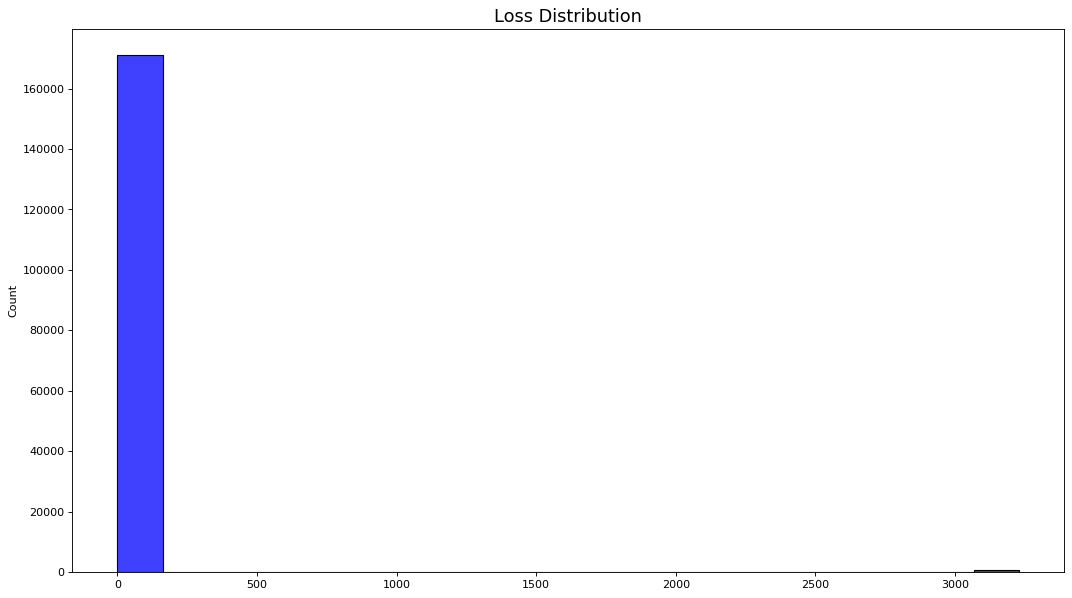

In [264]:
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.histplot(losses, bins = 20, kde= False, color = 'blue');
#sns.distplot(losses, bins = 20, kde= True, color = 'blue');

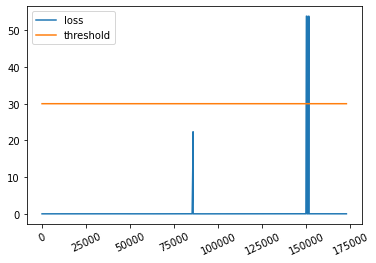

In [277]:
THRESHOLD =30


test_score_df = pd.DataFrame(index=range(len(losses)))
test_score_df['loss'] = [loss/60 for loss in losses]
test_score_df['y'] = y_test_per_window
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
#test_score_df['t'] = [x[59].item() for x in sequences]

plt.plot( test_score_df.loss, label='loss')
plt.plot( test_score_df.threshold, label='threshold')
#plt.plot( test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend();

In [278]:
import numpy as np
actual,predicted=improve_detection(test_score_df)

In [279]:

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

predicted = np.array(predicted)
actual = np.array(actual)

print_scores(predicted,actual)

True Positive	 1109
True Negative	 161966
False Positive	 2
False Negative	 9665
Accuracy	 0.9440379293975988
Precision	 0.9981998199819982
Recall	 0.10293298682012252
f-measure	 0.18662179217501054
cohen_kappa_score	 0.17702534768880418
auc	 0.5514603193509879
roc_auc	 0.5514603193509879
